In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import torch
from cot.data import BinaryCopy, Parity, Polynomial, MixedDataset
from cot.config import CHECK_DIR
from cot.models import TransformerConfig, Transformer

In [3]:
problem = "polynomial"
n_data_per_len = 1024
n_len=32
emb_dim=128
pos_dim = None
freeze_pos = False
n_head=1
n_layer=2
n_epochs = 1000
batch_size = 256
cot=True

In [4]:
subprocess.run(["python", "../src/cot/data/data_processing.py", 
                "--n_len", str(n_len),
                "--n_data_per_len", str(n_data_per_len),
                "--problem", problem,
                "--cot", str(cot),
                "--mod", str(5),
                ])

05-18 22:02:58 INFO [data_processing.py:56] Problem will  use CoT.
05-18 22:02:58 INFO [data_processing.py:82] Generating data. Saving in /checkpoint/vivc/data/binary_copy


CompletedProcess(args=['python', '../src/cot/data/data_processing.py', '--n_len', '32', '--n_data_per_len', '128', '--problem', 'binary-copy', '--cot', 'True', '--mod', '47'], returncode=0)

In [4]:
subprocess.run(["python", "../src/cot/train.py", 
                "--n_head", str(n_head),
                "--n_layer", str(n_layer),
                "--n_epochs", str(n_epochs),
                "--sgd", str(False),
                "--n_len", str(n_len), 
                "--batch_size", str(batch_size), 
                "--learning_rate", str(3e-4),
                "--emb_dim", str(emb_dim),
                "--pos_dim", str(pos_dim),
                "--freeze_pos", str(freeze_pos), 
                "--load_checkpoint", str(False),
                "--problem", problem,
                "--cot", str(cot),
                ])

05-18 22:30:43 INFO [data_processing.py:56] Problem will  use CoT.
05-18 22:30:43 INFO [data_processing.py:129] Loading data from /checkpoint/vivc/data/polynomial.
05-18 22:30:43 INFO [data_processing.py:56] Problem will  use CoT.
05-18 22:30:43 INFO [data_processing.py:129] Loading data from /checkpoint/vivc/data/polynomial.
05-18 22:30:43 INFO [train.py:152] Problem: polynomial. Number of training data: 16384.
05-18 22:30:45 INFO [train.py:184] Device used: cuda:1.
05-18 22:30:46 INFO [train.py:237] Starting Training from epoch 0.
05-18 22:30:47 INFO [train.py:266] Epoch     1, Loss: 89.8409
05-18 22:30:48 INFO [train.py:266] Epoch     2, Loss: 53.9971
05-18 22:30:49 INFO [train.py:266] Epoch     3, Loss: 51.7827
05-18 22:30:50 INFO [train.py:266] Epoch     4, Loss: 50.9747
05-18 22:30:51 INFO [train.py:266] Epoch     5, Loss: 49.6805
05-18 22:30:53 INFO [train.py:266] Epoch     6, Loss: 48.1435
05-18 22:30:54 INFO [train.py:266] Epoch     7, Loss: 44.4268
05-18 22:30:55 INFO [train.

CompletedProcess(args=['python', '../src/cot/train.py', '--n_head', '1', '--n_layer', '2', '--n_epochs', '1000', '--sgd', 'False', '--n_len', '32', '--batch_size', '256', '--learning_rate', '0.0003', '--emb_dim', '128', '--pos_dim', 'None', '--freeze_pos', 'False', '--load_checkpoint', 'False', '--problem', 'polynomial', '--cot', 'True'], returncode=0)

## Looking at the evaluation metrics

In [6]:
path = CHECK_DIR / problem.replace('-', '_') / 'model.pth'

checkpoint = torch.load(path)

timestamps = checkpoint['timestamps']
ind = timestamps != -1
timestamps = timestamps[ind]

evals = checkpoint['evals'][ind]
eval_dim = evals.shape[1] // 2

meaning = checkpoint['meaning']
assert len(meaning) == eval_dim

In [7]:
acc_by_len = evals[:, :n_len]
test_acc_by_len = evals[:, eval_dim:eval_dim + n_len]
spe_acc = evals[:, n_len:n_len + 3]
test_spe_acc = evals[:, eval_dim + n_len:eval_dim + n_len + 3]

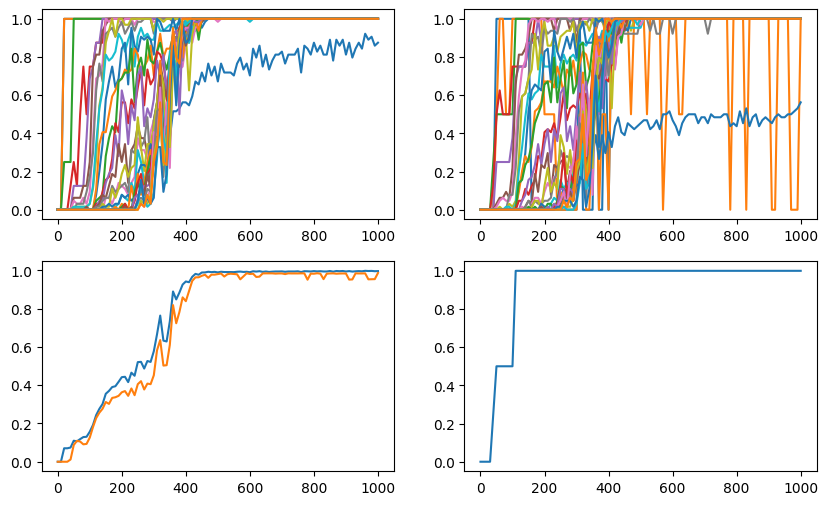

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(timestamps, acc_by_len)
axes[0, 1].plot(timestamps, test_acc_by_len)
axes[1, 0].plot(timestamps, acc_by_len.mean(axis=1))
axes[1, 0].plot(timestamps, test_acc_by_len.mean(axis=1))
axes[1, 1].plot(timestamps, spe_acc[:, 2])
# axes[1, 1].plot(timestamps, test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

## Looking at the model

In [9]:
token_emb = checkpoint['model_state_dict']['embeddings.token_emb.weight'].cpu()
pos_emb = checkpoint['model_state_dict']['embeddings.pos_emb.weight'].cpu()

In [10]:
lengths = list(np.arange(n_len) + 1)

if problem == 'parity':
    testset = Parity()
elif problem == 'binary-copy':
    testset = BinaryCopy(cot=cot)
elif problem == 'polynomial':
    testset = Polynomial(cot=cot)
elif problem == 'mix':
    testset = MixedDataset(cot=cot)
testset.set_data(lengths, data_type="test")

In [11]:
problem

'binary-copy'

In [12]:
config = TransformerConfig(
    vocab_size=torch.max(testset.data).item() + 1,
    emb_dim=emb_dim,
    pos_emb=True,
    pos_dim=pos_dim,
    freeze_pos=freeze_pos,
    seq_len=len(testset[0]),
    emb_dropout=0,
    n_head=n_head,
    n_layer=n_layer,
)

model = Transformer(config)
model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device=device)
model.eval()

Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(64, 128)
    (pos_emb): Embedding(67, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=64, bias=False)
)

In [13]:
model.blocks[1].ffn.parameters()

<generator object Module.parameters at 0x7f6665049700>

In [14]:
sequence = testset.data
# sequence = sequence.to(device=device, dtype=torch.long)

with torch.no_grad():
    logits, attentions = model(sequence, verbose=True)

We can extract the attention scores that we would like to maximize.

In [15]:
i = -1
attn00 = attentions[0, i, 0].cpu()
# attn01 = attentions[0, i, 1].cpu()
attn10 = attentions[1, i, 0].cpu()
# attn11 = attentions[1, i, 1].cpu()
# attn20 = attentions[2, i, 0].cpu()
# attn21 = attentions[2, i, 1].cpu()

In [16]:
attentions.shape

torch.Size([2, 1727, 1, 67, 67])

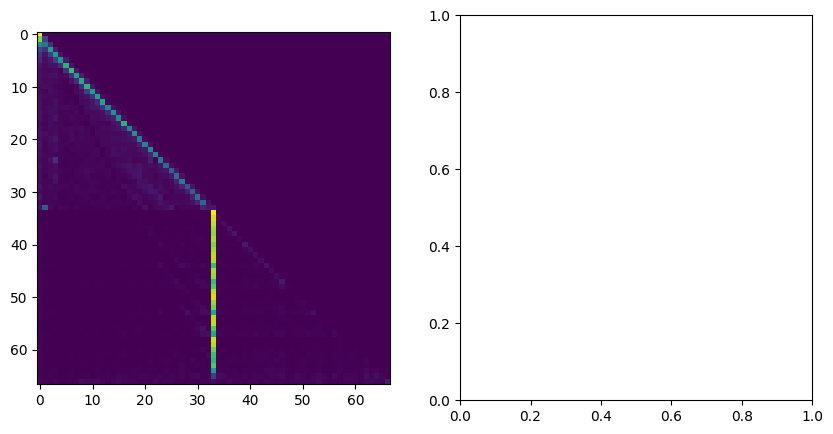

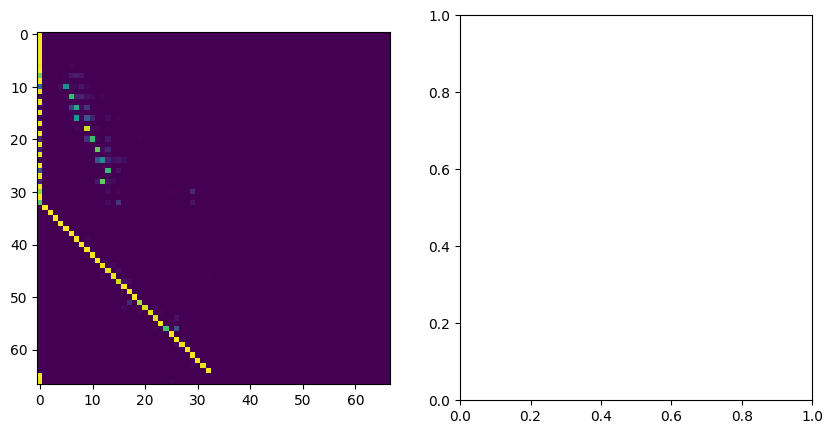

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn00)
# axes[1].imshow(attn01)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(attn10)
# axes[1].imshow(attn11)
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(attn20)
# axes[1].imshow(attn21)

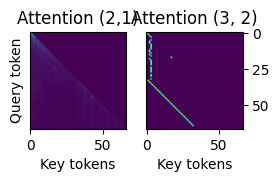

In [ ]:
WIDTH = 5.5
HEIGHT = WIDTH / 1.5
fig, axes = plt.subplots(1, 2, figsize=(.5 * WIDTH, .5 * HEIGHT))
axes[0].imshow(attn10)
axes[1].imshow(attn20 > .5)
axes[0].set_title('Attention (2,1)')
axes[1].set_title('Attention (3, 2)')
axes[0].set_xlabel('Key tokens')
axes[1].set_xlabel('Key tokens')
axes[0].set_ylabel('Query token')
axes[0].set_yticks([])
axes[1].yaxis.tick_right()
fig.savefig('attention_map_corrupted.pdf', bbox_inches="tight", dpi=300)

In [ ]:
sequence[i]

tensor([60,  0,  1,  0,  1,  0,  0,  1,  1,  1,  0,  1,  0,  0,  1,  1,  0, 62,
         0,  1,  0,  1,  0,  0,  1,  1,  1,  0,  1,  0,  0,  1,  1,  0, 63],
       dtype=torch.int32)